# Introduction Multi label classification

The dataset consists of two zip folders:

1. A folder containing movie posters sorted by year.
2. A folder containing metadata about the posters, stored in MongoDB format.

MongoDB is a NoSQL database where data is stored as collections of documents. The dataset contains approximately **8,052 images** and **8,870 metadata files**. Notably, there are more metadata files than images, meaning some metadata entries do not have corresponding posters.



## 1) Loading the Data

Before analyzing the dataset, we must first load it into a structured format. Since the metadata is stored in MongoDB format, we need to parse it into a readable format like JSON and load it using Pandas.

In [1]:
metadata_folder = './data/Movie_Poster_Metadata'
poster_folder = './data/Movie_Poster_Dataset'

Before the data can be parsed, there need to be some helper functions.

In [2]:
import json
import os
import re

def parse_metadata(string):
    """Parse MongoDB-style text data to JSON."""
    # Find all JSON-like structures in the string
    matches = re.findall(r"(\{.*?\})", string, re.DOTALL)
    result = []

    for match in matches:
            # Remove the ObjectId(*)
            clean_json = re.sub(r'ObjectId\("([^"]*)"\)', r'"\1"', match)
            movie_obj = json.loads(clean_json)
            result.append(movie_obj)
    
    return result

def read_file(filepath):
    """Read file with proper encoding."""
    try:
        # Try UTF-16 encoding first
        with open(filepath, 'r', encoding='utf-16') as file:
            return file.read()
    except:
        # Fall back to UTF-8 encoding
        with open(filepath, 'r', encoding='utf-8') as file:
            return file.read()

In [3]:
import pandas as pd

def load_movie_metadata():
    """Load all movie metadata from files."""
    filenames = os.listdir(metadata_folder)
    poster_data = pd.DataFrame()
    
    for filename in filenames:
        filepath = os.path.join(metadata_folder, filename)
        content = read_file(filepath)
        data = parse_metadata(content)
    
    
        poster_data = pd.concat([poster_data, pd.DataFrame(data)])
    
    print(f"Loaded metadata for {len(poster_data)} movies")
    return poster_data

# Load the movie metadata
metadata = load_movie_metadata()
metadata.head()

Loaded metadata for 8873 movies


,_id,Language,Box_office,Country,Rated,imdbID,Awards,Poster,Director,Released,Writer,imdbVotes,Runtime,Response,imdbRating,Title,Genre,Actors,Type,Metascore
0,56fb860e71a0651b0c306f55,English,"290,158,751",USA,PG,tt0080684,Won 1 Oscar. Another 15 wins & 18 nominations.,http://ia.media-imdb.com/images/M/MV5BMjE2MzQw...,Irvin Kershner,20 Jun 1980,"Leigh Brackett (screenplay), Lawrence Kasdan (...","799,579",124 min,True,8.8,Star Wars: Episode V - The Empire Strikes Back,"Action, Adventure, Fantasy","Mark Hamill, Harrison Ford, Carrie Fisher, Bil...",movie,79
1,56fb860e71a0651b0c306f56,English,"101,500,000",USA,R,tt0081562,1 nomination.,http://ia.media-imdb.com/images/M/MV5BMTM4OTI3...,Sidney Poitier,12 Dec 1980,Bruce Jay Friedman,"17,705",111 min,True,6.8,Stir Crazy,"Comedy, Crime","Gene Wilder, Richard Pryor, Georg Stanford Bro...",movie,50
2,56fb860e71a0651b0c306f57,English,"83,400,000",USA,PG,tt0080339,Nominated for 1 Golden Globe. Another 2 wins &...,http://ia.media-imdb.com/images/M/MV5BNDU2MjE4...,"Jim Abrahams, David Zucker, Jerry Zucker",02 Jul 1980,"Jim Abrahams (written for the screen by), Davi...","154,994",88 min,True,7.8,Airplane!,Comedy,"Kareem Abdul-Jabbar, Lloyd Bridges, Peter Grav...",movie,N/A
3,56fb860e71a0651b0c306f58,English,None,USA,PG,tt0080377,1 win.,http://ia.media-imdb.com/images/M/MV5BMTc5MTc5...,Buddy Van Horn,17 Dec 1980,"Jeremy Joe Kronsberg (characters), Stanford Sh...","12,639",116 min,True,6.0,Any Which Way You Can,"Action, Comedy","Clint Eastwood, Sondra Locke, Geoffrey Lewis, ...",movie,N/A
4,56fb860e71a0651b0c306f59,English,"69,800,000",USA,R,tt0081375,Nominated for 3 Oscars. Another 1 win & 3 nomi...,http://ia.media-imdb.com/images/M/MV5BMjIyNjkx...,Howard Zieff,10 Oct 1980,"Nancy Meyers, Charles Shyer, Harvey Miller","17,591",109 min,True,6.1,Private Benjamin,"Comedy, War","Goldie Hawn, Eileen Brennan, Armand Assante, R...",movie,N/A


Now that we have the metadata, we need to link it with the corresponding images. Some metadata entries may not have associated images, so we must filter them out.


In [4]:
available_images = set()

for year in os.listdir(poster_folder):
    for poster in os.listdir(f"{poster_folder}/{year}"):
        available_images.add(poster.split('.')[0])

print(f"Available images: {len(available_images)}")

Available images: 8052


In [5]:
metadata["image_exists"] = metadata["imdbID"].apply(lambda x: x in available_images)
md_without_images = metadata.loc[metadata['image_exists'] == False, :].copy()

print(f"These are {len(md_without_images)} metadata files without any pictures.")
print(f"There are {len(metadata) - len(md_without_images)} metadata files with pictures.")

metadata = metadata.loc[metadata['image_exists'] == True, :].copy()

These are 809 metadata files without any pictures.
There are 8064 metadata files with pictures.


We can see there are 8052 pictures and 8064 metadata files so there should be duplicates in the dataframe. These should be filtered out.

In [6]:
metadata = metadata.drop_duplicates(subset=['imdbID'])
print(len(metadata))

8052



After merging, we notice some metadata entries are missing images, leading to a reduced dataset.


## 2) Understanding the Dataset

### **What is the distribution of images per year?**

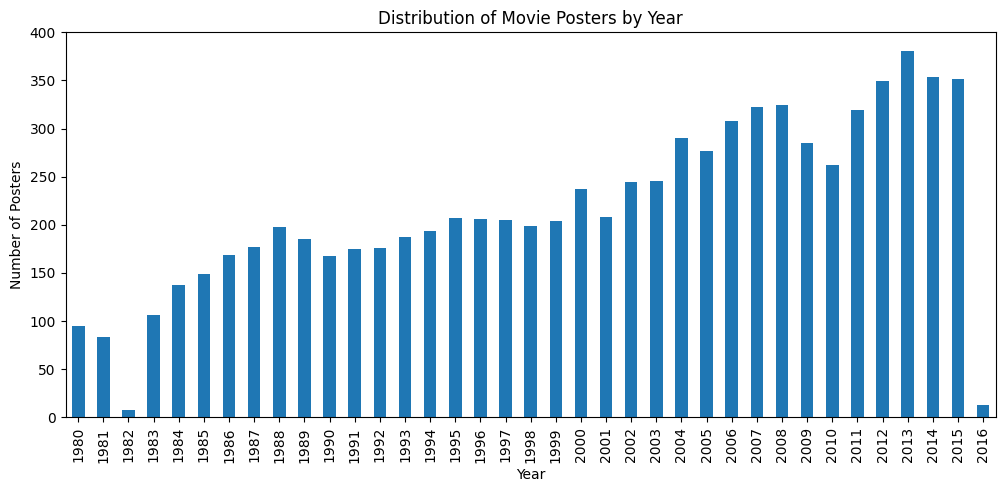

In [7]:
import matplotlib.pyplot as plt

metadata['year'] = pd.to_datetime(metadata['Released'], errors='coerce').dt.year
metadata['year'].dropna().astype(int).value_counts().sort_index().plot(kind='bar', figsize=(12,5))

plt.title('Distribution of Movie Posters by Year')
plt.xlabel('Year')
plt.ylabel('Number of Posters')
plt.show()

### **What genres are available?**

In [8]:
unique_genres = set()
for movie_genres in metadata['Genre']:
    if not movie_genres or isinstance(movie_genres, float):
        continue
    movie_genres = movie_genres.split(',')
    for genre in movie_genres:
        if genre == 'n/a' or genre == 'N/A':
            continue
        
        unique_genres.add(genre.strip())
classnames = list(unique_genres)

print(f"Found {len(classnames)} genres")
print(unique_genres)

Found 24 genres
{'Animation', 'Family', 'Documentary', 'Romance', 'Musical', 'Thriller', 'Comedy', 'Short', 'Horror', 'Sport', 'Sci-Fi', 'Drama', 'Western', 'Biography', 'Adventure', 'Crime', 'Action', 'Mystery', 'Fantasy', 'Reality-TV', 'Music', 'History', 'War', 'News'}


## 3) Image Properties

Some movie posters are in **landscape orientation**, which might not be suitable for training. Let's analyze how many landscape images exist.

In [9]:
from PIL import Image

landscape_images = []

for year in os.listdir(poster_folder):
    for img_file in os.listdir(os.path.join(poster_folder, year)):
        img = Image.open(os.path.join(poster_folder, year, img_file))
        if img.width > img.height:
            landscape_images.append(img_file.split('.')[0])

print(f"Landscape images: {len(landscape_images)} ({(len(landscape_images) / len(available_images)) * 100:.2f}%)")

Landscape images: 85 (1.06%)


Since landscape images make up only about **1% of the dataset**, we can remove them.

In [10]:
metadata = metadata[~metadata['imdbID'].isin(landscape_images)]
print(f"New metadata lenght: {len(metadata)}")

New metadata lenght: 7967


## 4) Image Preprocessing

Using a standard image size like 224x224 allows us to compare our model with existing models from the internet.


In [11]:
from PIL import Image, ImageOps

def resize_with_padding(image_path, output_size=(224, 224)):
    img = Image.open(image_path)
    padded_img = ImageOps.pad(img, output_size, color="black")
    return padded_img



In [12]:
processed_image_output = './data/processed'
images_to_resize = metadata['imdbID'].unique()

if not os.path.exists(processed_image_output):
    os.mkdir(processed_image_output)

for year in os.listdir(poster_folder):
    for poster in os.listdir(f"{poster_folder}/{year}"):
        imdbID = poster.split('.')[0]

        if imdbID not in metadata['imdbID'].unique():
            continue

        new_path = os.path.join(processed_image_output, poster)
        print(new_path)

        new_image = resize_with_padding(os.path.join(poster_folder, year, poster))
        new_image.save(new_path)

./data/processed\tt0079285.jpg
./data/processed\tt0079302.jpg
./data/processed\tt0080339.jpg
./data/processed\tt0080360.jpg
./data/processed\tt0080365.jpg
./data/processed\tt0080377.jpg
./data/processed\tt0080402.jpg
./data/processed\tt0080437.jpg
./data/processed\tt0080442.jpg
./data/processed\tt0080453.jpg
./data/processed\tt0080455.jpg
./data/processed\tt0080461.jpg
./data/processed\tt0080469.jpg
./data/processed\tt0080472.jpg
./data/processed\tt0080474.jpg
./data/processed\tt0080487.jpg
./data/processed\tt0080500.jpg
./data/processed\tt0080520.jpg
./data/processed\tt0080549.jpg
./data/processed\tt0080550.jpg
./data/processed\tt0080556.jpg
./data/processed\tt0080569.jpg
./data/processed\tt0080634.jpg
./data/processed\tt0080661.jpg
./data/processed\tt0080678.jpg
./data/processed\tt0080684.jpg
./data/processed\tt0080724.jpg
./data/processed\tt0080731.jpg
./data/processed\tt0080736.jpg
./data/processed\tt0080739.jpg
./data/processed\tt0080745.jpg
./data/processed\tt0080749.jpg
./data/p

For training we won't need all colums so im dropping the columns who are not necesarry

In [13]:
dataset = metadata.loc[:, ['imdbID', 'Genre']].copy()
dataset.head()

,imdbID,Genre
0,tt0080684,"Action, Adventure, Fantasy"
1,tt0081562,"Comedy, Crime"
2,tt0080339,Comedy
3,tt0080377,"Action, Comedy"
4,tt0081375,"Comedy, War"


In [14]:
dataset.to_excel('./data/data.xlsx', index=False, engine='openpyxl')